+Training

In [14]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os
from sklearn.utils import shuffle
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import json
import pandas as pd

In [2]:
#Чтение датасетов
mylist= os.listdir('RawData/')

#Список эмоций
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')
        
labels = pd.DataFrame(feeling_list)

In [3]:
#Выделение признаков
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1     

In [4]:
#Преобразование
df3 = pd.DataFrame(df['feature'].values.tolist())
newdf = pd.concat([df3,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})
rnewdf = shuffle(newdf)
rnewdf=rnewdf.fillna(0)

In [5]:
#Разделение на тестовые и тренировочные данные
newdf1 = np.random.rand(len(rnewdf)) < 0.7
train = rnewdf[newdf1]
test = rnewdf[~newdf1]
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

C:\Users\pepega\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [6]:
#Создание модели
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [7]:
#Тренировка нейронной сети
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=750, validation_data=(x_testcnn, y_test))

Epoch 1/750
46/46 [==============================] - 5s 85ms/step - loss: 2.5347 - accuracy: 0.0975 - val_loss: 2.3010 - val_accuracy: 0.0966
Epoch 2/750
46/46 [==============================] - 3s 60ms/step - loss: 2.3623 - accuracy: 0.1258 - val_loss: 2.2756 - val_accuracy: 0.1212
Epoch 3/750
46/46 [==============================] - 3s 60ms/step - loss: 2.3406 - accuracy: 0.1174 - val_loss: 2.2577 - val_accuracy: 0.1166
Epoch 4/750
46/46 [==============================] - 3s 61ms/step - loss: 2.2854 - accuracy: 0.1246 - val_loss: 2.2411 - val_accuracy: 0.1258
Epoch 5/750
46/46 [==============================] - 3s 60ms/step - loss: 2.2622 - accuracy: 0.1573 - val_loss: 2.2246 - val_accuracy: 0.1472
Epoch 6/750
46/46 [==============================] - 3s 64ms/step - loss: 2.2587 - accuracy: 0.1439 - val_loss: 2.2101 - val_accuracy: 0.2055
Epoch 7/750
46/46 [==============================] - 3s 61ms/step - loss: 2.2262 - accuracy: 0.1534 - val_loss: 2.1995 - val_accuracy: 0.2025
Epoch 

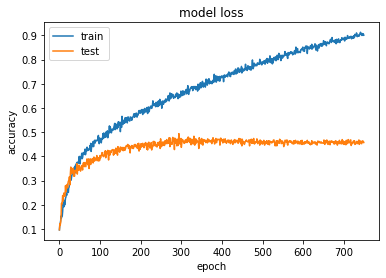

In [8]:
#График
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
#Сохранение модели
model_name = 'SpeechEmotionDetection.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Saved trained model at C:\Users\pepega\saved_models\SpeechEmotionDetection.h5 


In [ ]:
Предсказание модели

In [19]:
import numpy as np
import os
import pandas as pd
import librosa
import glob
import keras
from keras.models import model_from_json

In [20]:
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [21]:
#Предсказание
X, sample_rate = librosa.load('test/male_happy1.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)


featurelive = mfccs
livedf2 = featurelive

livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
twodim= np.expand_dims(livedf2, axis=2)

livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

feelingList = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
print(feelingList[np.argmax(livepreds)])

1/1 [==============================] - 0s 151ms/step
male_angry
